#### We will implement simplified black-box attacks (i.e., you do not have any access to the target model and its parameters) and evaluate transferability. The target model that we are attacking is trained on the MNIST dataset of 28×28 pixel images of handwritten digits, and we don’t know any other details. we decide to collect ten images from each dataset class (numbers 0-9) to train your substitute model (also called auxiliary or surrogate model). we can use any dataset available online to have your own training dataset.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8585933483455051331
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14976993196474310133
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd '/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4/network'

In [ ]:
!ls

drive  sample_data


In [ ]:
!pwd

/content


In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 27.2 MB/s 


In [ ]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from art.attacks.evasion import CarliniL2Method, SaliencyMapMethod, ElasticNet
from art.estimators.classification import KerasClassifier

# Set the random seeds. Do not change this!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Define some constants.
NUM_CLASSES = 10
BATCH_SIZE = 32

#######
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

## Part 1

### You need to complete the following.

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')

# Reshape the data.
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train[2])

(60000, 1, 28, 28)
(10000, 1, 28, 28)
(60000, 10)
(10000, 10)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# Build a training dataset for the substitute model
# Collect ten images from each dataset class (numbers 0-9)
selected_examples = []
for target_label in range(0, 10):
    count = 0
    for i in range(y_train.shape[0]):
        if y_train[i].tolist().index(1) == target_label:
            count += 1
            selected_examples.append((x_train[i, :, :], y_train[i]))
            if count == 10:
                break



In [ ]:
type(selected_examples)

list

In [ ]:
# Convert selected examples to numpy array
final_train_x = np.array([ele[0] for ele in selected_examples])
final_train_y = np.array([ele[1] for ele in selected_examples])

In [ ]:
print(final_train_x.shape)
print(final_train_y.shape)
print(final_train_y[99])

(100, 1, 28, 28)
(100, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# Train a CNN-based substitute model using the newly collected dataset
substitute_model = Sequential()

# Define the intermediate layers.
substitute_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,28,28)))

#64 convolution filters used each of size 3x3
substitute_model.add(Conv2D(64, (3, 3), activation='relu'))

#choose the best features via pooling
substitute_model.add(MaxPooling2D(pool_size=(2, 2)))

#To improve convergence
substitute_model.add(Dropout(0.25))

#flatten
substitute_model.add(Flatten())

# #fully connected
substitute_model.add(Dense(128, activation='relu'))

#add one more dropout for convergence
substitute_model.add(Dropout(0.5))

substitute_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
substitute_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

substitute_model = KerasClassifier(model=substitute_model, clip_values=(0,1))

# Fit the model
substitute_model.fit(final_train_x, final_train_y, nb_epochs=10, batch_size=BATCH_SIZE)

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 10s 97ms/sample - loss: 2.2899 - accuracy: 0.1400
Epoch 2/10
100/100 [==============================] - 0s 299us/sample - loss: 2.0018 - accuracy: 0.3800
Epoch 3/10
100/100 [==============================] - 0s 445us/sample - loss: 1.6384 - accuracy: 0.5300
Epoch 4/10
100/100 [==============================] - 0s 361us/sample - loss: 1.2825 - accuracy: 0.6600
Epoch 5/10
100/100 [==============================] - 0s 459us/sample - loss: 0.9360 - accuracy: 0.7200
Epoch 6/10
100/100 [==============================] - 0s 350us/sample - loss: 0.8223 - accuracy: 0.7600
Epoch 7/10
100/100 [==============================] - 0s 312us/sample - loss: 0.7132 - accuracy: 0.7700
Epoch 8/10
100/100 [==============================] - 0s 313us/sample - loss: 0.4940 - accuracy: 0.8500
Epoch 9/10
100/100 [==============================] - 0s 319us/sample - loss: 0.4495 - accuracy: 0.8300
Epoch 10/10
100/100 [======================

    Please ONLY use the following attack methods.

In [ ]:
# Define methods for generating "targetted" adversarial examples
def generate_adv_examples_CarliniL2Method(classifier, x, target_y):
    attack = CarliniL2Method(classifier,targeted=True)
    return attack.generate(x,target_y)

def generate_adv_examples_ElasticNet(classifier, x, target_y):
    attack = ElasticNet(classifier,targeted=True)
    return attack.generate(x,target_y)

def generate_adv_examples_SaliencyMapMethod(classifier, x, target_y):
    attack = SaliencyMapMethod(classifier)
    return attack.generate(x,target_y)

In [ ]:
# Build a mapping from the true label to the fake label
# For example, in the mapping below, we want the classifier to predict 0 images as 8.
label_map = {0:8, 1:9, 2:3, 3:5, 4:6, 5:7, 6:4, 7:2, 8:1, 9:0}
for k, v in label_map.items():
    assert(k != v)
assert(len(set(label_map.keys())) == 10)
assert(len(set(label_map.values())) == 10)

# Build target_y
target_y_labels = []
for i in range(final_train_y.shape[0]):
    cur_true_label = final_train_y[i].tolist().index(1)
    target_label = label_map[cur_true_label]
    target_y_labels.append(target_label)
target_y_labels = np.asarray(target_y_labels)
target_y = keras.utils.to_categorical(target_y_labels, NUM_CLASSES)


In [ ]:
# Generate 100 adversarial images
carlinil_adv_examples = generate_adv_examples_CarliniL2Method(substitute_model,final_train_x,target_y)

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
from sklearn.metrics import accuracy_score

predictions = substitute_model.predict(carlinil_adv_examples)
carlinil_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

For CarliniL2Method attack, MR = 0.22


In [ ]:
# Generate 100 adversarial images
elastic_net_adv_examples = generate_adv_examples_ElasticNet(substitute_model,final_train_x,target_y)

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Generate 100 adversarial images
saliency_adv_examples = generate_adv_examples_SaliencyMapMethod(substitute_model,final_train_x,target_y)

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Calculate Misclassification Ratio (MR) for CarliniL2Method attack
from sklearn.metrics import accuracy_score

predictions = substitute_model.predict(carlinil_adv_examples)
carlinil_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

# Calculate Misclassification Ratio (MR) for ElasticNet attack
predictions = substitute_model.predict(elastic_net_adv_examples)
elastic_net_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For ElasticNet attack, MR = {}'.format(elastic_net_mr))

# Calculate Misclassification Ratio (MR) for SaliencyMapMethod attack
predictions = substitute_model.predict(saliency_adv_examples)
saliency_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For SaliencyMapMethod attack, MR = {}'.format(saliency_mr))

For CarliniL2Method attack, MR = 0.22
For ElasticNet attack, MR = 0.92
For SaliencyMapMethod attack, MR = 1.0


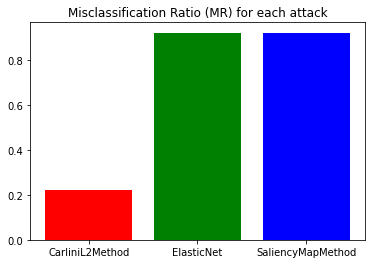

In [ ]:
# Make a plot
X = ['CarliniL2Method','ElasticNet', 'SaliencyMapMethod']
plt.bar(X,[carlinil_mr,elastic_net_mr,elastic_net_mr], color=['r', 'g', 'b'])
plt.title('Misclassification Ratio (MR) for each attack')
plt.show()
plt.close()

## Part 2

### You need to complete the following.

In [ ]:
final_train_y.shape

(100, 10)

In [ ]:
# Imports
from numpy import linalg as LA

for class_label in range(0, 10):
    print('For images of true class = {}'.format(class_label))
    norms_average = {"carlinil": {'l0':0,'l2':0,'l_inf':0}, "elastic_net": {'l0':0,'l2':0,'l_inf':0}, "saliency": {'l0':0,'l2':0,'l_inf':0} }
    
    for i in range(final_train_y.shape[0]):
        cur_true_label = final_train_y[i].tolist().index(1)
        if cur_true_label == class_label:
            for attack_method in ['carlinil', 'elastic_net', 'saliency']:
                if attack_method == 'carlinil': cur_adv_examples=carlinil_adv_examples
                  # carlinil_l0=LA.norm(carlinil_adv_examples[i],1)
                  # carlinil_l2=LA.norm(carlinil_adv_examples[i],2)
                  # carlinil_linf=LA.norm(carlinil_adv_examples[i],inf)
                elif attack_method == 'elastic_net': cur_adv_examples=elastic_net_adv_examples
                elif attack_method == 'saliency': cur_adv_examples=saliency_adv_examples
                x_diff = (final_train_x[i].squeeze() - cur_adv_examples[i].squeeze()).reshape(-1)
                norms_average[attack_method]['l0'] += LA.norm(x_diff,0)
                norms_average[attack_method]['l2'] += LA.norm(x_diff,2)
                norms_average[attack_method]['l_inf'] += LA.norm(x_diff,np.inf)
            
    print('Methods \t L0 \t L2 \t L_inf')
    for attack_method in ['carlinil', 'elastic_net', 'saliency']:
        l0_average = norms_average[attack_method]['l0']/10
        l2_average = norms_average[attack_method]['l2']/10
        linf_average = norms_average[attack_method]['l_inf']/10
        print('{} \t {} \t {} \t {}'.format(attack_method, l0_average, l2_average, linf_average))
    print('\n')


For images of true class = 0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 258.6 	 0.03153639007207711 	 0.007154470903532833
elastic_net 	 263.6 	 1.7094131597709457 	 0.4244403458536551
saliency 	 204.4 	 3.1282337713424235 	 0.9700000091185113


For images of true class = 1
Methods 	 L0 	 L2 	 L_inf
carlinil 	 164.4 	 0.15187634365539499 	 0.0359972787347754
elastic_net 	 144.3 	 1.437998189946112 	 0.45645425307552384
saliency 	 101.0 	 2.6418002797574207 	 1.0


For images of true class = 2
Methods 	 L0 	 L2 	 L_inf
carlinil 	 530.5 	 0.7807958836834683 	 0.3082036587330629
elastic_net 	 244.7 	 1.4764724768892004 	 0.5673485354968324
saliency 	 187.5 	 2.707346388430333 	 0.9879684005483916


For images of true class = 3
Methods 	 L0 	 L2 	 L_inf
carlinil 	 293.9 	 0.2856092365184077 	 0.06938494694176607
elastic_net 	 221.8 	 1.5007922779595055 	 0.3760474358153888
saliency 	 178.7 	 4.036919302422559 	 1.0


For images of true class = 4
Methods 	 L0 	 L2 	 L_inf
carlinil 	 209.1 	 0.118

## Part 3

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4')
import network

### You need to complete the following.

In [ ]:
!pwd
!ls -r
%cd '/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4'
!pwd

/content
sample_data  drive
/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4
/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4


In [ ]:
# Imports

# Reload the trained model from HW#3 Problem 4
import network.network as Network
import network.network as mnist_loader
import pickle

# Load the pre-trained model.
with open('./network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    target_net = u.load()

In [ ]:
dir(mnist_loader)

['Network',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'np',
 'random',
 'sigmoid',
 'sigmoid_prime']

In [ ]:
!cd ./network/

In [ ]:
!pwd

/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4


In [ ]:
def predict_using_target_net(x, verbose=False):
    x = x.squeeze().reshape(-1, 1)
    outputs = target_net.feedforward(x)
    predictions = np.argmax(outputs)
    if verbose:
        print('Network output: \n' + str(np.round(outputs, 2)) + '\n')
        print('Network prediction: ' + str(predictions) + '\n')
        print('Actual image: ')
    
        # Draw the image
        plt.imshow(x.reshape((28,28)), cmap='Greys')
    return predictions

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

Network prediction: 7

Actual image: 
7


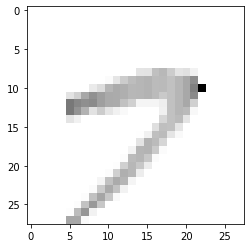

In [ ]:
print(predict_using_target_net(final_train_x[78], True))

In [ ]:
# Evaluate whether adversarial examples generated with the substitute model will transfer to the target model
for attack_method in ['carlinil', 'elastic_net', 'saliency']:
    model_preds=[]
    if attack_method == 'carlinil': 
      for img in carlinil_adv_examples:
        model_preds.append(predict_using_target_net(img))
    elif attack_method == 'elastic_net': 
      for img in elastic_net_adv_examples:
        model_preds.append(predict_using_target_net(img))
    elif attack_method == 'saliency':
      for img in saliency_adv_examples:
        model_preds.append(predict_using_target_net(img))
    predictions = model_preds
    predictions = np.asarray(predictions)
    mr = accuracy_score(predictions, np.argmax(target_y,axis=1))
    print('For {}, Misclassification Ratio = {}'.format(attack_method, mr))

For carlinil, Misclassification Ratio = 0.03
For elastic_net, Misclassification Ratio = 0.17
For saliency, Misclassification Ratio = 0.14


Here Mr follows the same definations as above : % of adv examples classedfied as the target y labels

## Part 4

### You need to complete the following.

In [ ]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [ ]:
# Re-load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

nb_trains = x_train.shape[0]
nb_tests = x_test.shape[0]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train[1])

(60000, 28, 28)
(60000,)
0


In [ ]:
x_train = x_train.reshape((x_train.shape[0],28*28))
x_test = x_test.reshape((x_test.shape[0],28*28))

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
# x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
# x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train[1])
print(len(x_train[0]))

(60000, 784)
(60000,)
0
784


In [ ]:
# ANN model
ann_parameters = {
'hidden_layer_sizes': [(100), (100,100)]
}

ann_clf = GridSearchCV(MLPClassifier(),ann_parameters,scoring='accuracy')
ann_clf.fit(x_train,y_train)
print(ann_clf.best_params_)


{'hidden_layer_sizes': (100, 100)}


In [ ]:
print(ann_clf.best_score_)

0.9715333333333334


In [ ]:
# SVM model
svm_parameters = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

svm_clf = GridSearchCV(SVC(),svm_parameters)
svm_clf.fit(x_train,y_train)
print(svm_clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [ ]:
print(svm_clf.best_score_)

0.9795666666666667


In [ ]:
# Logistic Regression model
lr_parameters = {
    'multi_class': ['auto'],
    'penalty' : ['l1', 'l2'],
    'C': [1, 10],
}

lr_clf = GridSearchCV(LogisticRegression(),lr_parameters)
lr_clf.fit(x_train,y_train)
print(lr_clf.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'C': 1, 'multi_class': 'auto', 'penalty': 'l2'}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(lr_clf.best_score_)

0.9191499999999999


In [ ]:
# kNN
knn_parameters = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance']
}
knn_clf = GridSearchCV(KNeighborsClassifier(),knn_parameters)
knn_clf.fit(x_train,y_train)
print(knn_clf.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
print(knn_clf.best_score_)

0.9588333333333333


In [ ]:
# Naive Bayes
naive_bayes_parameters = {
    'var_smoothing': [1e-3, 1e-2, 1e-1]
}
naive_bayes_clf = GridSearchCV(estimator=GaussianNB(), param_grid=naive_bayes_parameters)
naive_bayes_clf.fit(x_train,y_train)
print(naive_bayes_clf.best_params_)

{'var_smoothing': 0.1}


In [ ]:
# Voting classifiers
voting_clf = VotingClassifier(estimators=[
                                ('naive_bayes', GaussianNB()),
                                ('ann', MLPClassifier()),
                                ('lr', LogisticRegression()),
                               ], voting='soft')

params = {
          'naive_bayes__var_smoothing': [1e-3, 1e-2, 1e-1],
          'lr__C': [1, 10],
          'ann__hidden_layer_sizes': [(100), (100,100)]
          }

voting_clf = GridSearchCV(voting_clf,params)
voting_clf.fit(x_train,y_train)
print(voting_clf.best_params_)
## used best_param_ instead of best_params_ --- So corrected it in next line

In [ ]:
print(voting_clf.best_params_)
print(voting_clf.best_score_)

{'ann__hidden_layer_sizes': (100, 100), 'lr__C': 10, 'naive_bayes__var_smoothing': 0.001}
0.9434833333333333


In [ ]:
classifier_names = ['ANN', 'SVM', 'Logistic Regression', 'kNN', 'Naive Bayes', 'Voting classifiers']
classifiers = [ann_clf, svm_clf, lr_clf, knn_clf, naive_bayes_clf, voting_clf]
print('Methods \t Test Acc \t Carlinil MR \t ElasticNet MR \t Saliency MR')
for i in range(len(classifiers)):

    preds=classifiers[i].predict(x_test)
    preds_carlini=classifiers[i].predict(carlinil_adv_examples.reshape(100,28*28))
    preds_elastic_net=classifiers[i].predict(elastic_net_adv_examples.reshape(100,28*28))
    preds_saliency=classifiers[i].predict(saliency_adv_examples.reshape(100,28*28))

    test_acc = accuracy_score(preds, y_test)
    carlinil_acc = accuracy_score(preds_carlini, np.argmax(target_y,axis=1))
    elasticnet_acc = accuracy_score(preds_elastic_net, np.argmax(target_y,axis=1))
    saliency_acc = accuracy_score(preds_saliency, np.argmax(target_y,axis=1))
    print('{} \t {} \t {} \t {} \t {}'.format(classifier_names[i], str(test_acc), str(carlinil_acc), str(elasticnet_acc), str(saliency_acc)))

Methods 	 Test Acc 	 Carlinil MR 	 ElasticNet MR 	 Saliency MR
ANN 	 0.9753 	 0.04 	 0.15 	 0.14
SVM 	 0.9817 	 0.04 	 0.16 	 0.12
Logistic Regression 	 0.9243 	 0.07 	 0.22 	 0.16
kNN 	 0.9622 	 0.0 	 0.04 	 0.03
Naive Bayes 	 0.8073 	 0.1 	 0.25 	 0.32
Voting classifiers 	 0.9461 	 0.06 	 0.15 	 0.08


The MR for substitute model was 
For CarliniL2Method attack, MR = 0.22
For ElasticNet attack, MR = 0.92
For SaliencyMapMethod attack, MR = 1.0

However here the Values are:
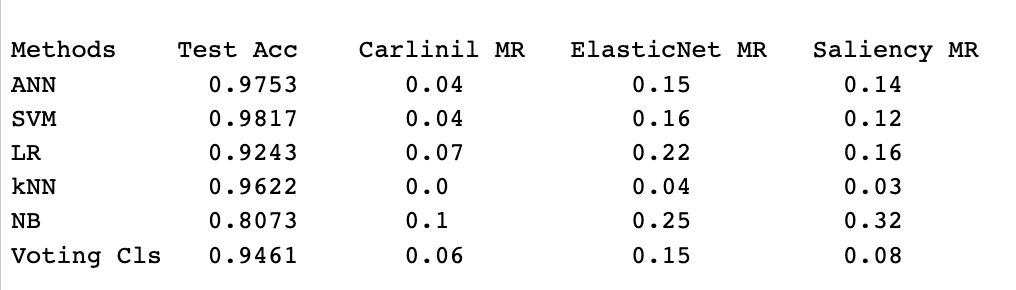
Methods 	 Test Acc 	 Carlinil MR 	 ElasticNet MR 	 Saliency MR
ANN 	       0.9753 	    0.04 	         0.15 	       0.14
SVM 	       0.9817 	    0.04 	         0.16 	       0.12
LR 	         0.9243 	    0.07 	         0.22 	       0.16
kNN 	       0.9622 	    0.0 	         0.04 	       0.03
NB           0.8073 	    0.1 	         0.25 	       0.32
Voting Cls 	 0.9461 	    0.06 	         0.15 	       0.08


We can see that specially for Elastic MR attack, it has nt trasnferred well from subtitute to these 6 models. we see a drop in MR from 0.92 to around ~0.20 for majority of them

same trend in noticed in all of them. Hence we can see that its not as trasnfarable and we see a drop in MR accuracy 

In [ ]:
carlinil_adv_examples.shape

(100, 1, 28, 28)

In [ ]:
preds_carlini[0]

0

In [ ]:
def preprocess(dir):
    # To deal with the error when there is [] in the path
    dir.replace('[','[[]')
    dir.replace(']','[]]')
    return dir

########################        YOUR CODE        ##########################
your_ipynb_file_dir = '/content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4/Problem2_work_copy.ipynb' # Example: '/content/drive/MyDrive/ECE570/Assignment_02_Exercise.ipynb'
########################      END YOUR CODE      ##########################

!jupyter nbconvert --to html '{preprocess(your_ipynb_file_dir)}'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4/Problem2_work_copy.ipynb to html
[NbConvertApp] Writing 488354 bytes to /content/drive/MyDrive/Purdue/SEM1/CS 529/Assignments/A4/Problem2_work_copy.html
